In [1]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Loading Data
data = pd.read_csv('/home/nicolas/Documentos/Diplomatra en ciencia de datos aplicada/Datasets/data.csv')
tag = pd.read_csv('/home/nicolas/Documentos/Diplomatra en ciencia de datos aplicada/Datasets/tag.csv')

In [3]:
pd.set_option('display.max_columns',30)

In [4]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [5]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [6]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [7]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

In [8]:
tag.head()

,SUSCRIBER_KEY,Total
0,E_63734494_20190215,0
1,E_66977552_20190518,0
2,E_69159695_20180116,4
3,E_65255730_20190416,3
4,E_67893872_20161201,0


Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [9]:
tag['Total']= tag['Total']==0

In [10]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [11]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,True
1,E_66977552_20190518,True
2,E_69159695_20180116,False
3,E_65255730_20190416,False
4,E_67893872_20161201,True


In [12]:
tag['Target'] = tag['Target'].astype(int)

In [13]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,1
1,E_66977552_20190518,1
2,E_69159695_20180116,0
3,E_65255730_20190416,0
4,E_67893872_20161201,1


In [14]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

 Unimos los datasets

In [15]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


In [16]:
del tag
del data

In [17]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 213 entries, SUSCRIBER_KEY to Target
dtypes: float64(103), int64(98), object(12)
memory usage: 521.2+ MB


 ## Empecemos a limpiar columnas 

Todas las que dicen en el documento 'No se usa', Chau

In [18]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

In [19]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [20]:
que_quedaron= ["USE_LCL_VOI_AMT_M1",
"USE_LCL_VOI_AMT_M2",
"USE_LCL_VOI_AMT_M3",]

In [21]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [22]:
fulldata.shape

(319222, 192)

In [23]:
print(fulldata.columns)

Index(['SUSCRIBER_KEY', 'FECHA_CORTE', 'LAT_PROV_BTS', 'LON_PROV_BTS',
       'LAT_CITY_BTS', 'LON_CITY_BTS', 'VALUE_SEGMENT', 'SEGMENTATION',
       'MICROSEGMENTATION', 'SOURCE',
       ...
       'PACK_DATA_EXP_W4', 'PACK_DATA_EXP_W5', 'PACK_DATA_EXP_W6',
       'PACK_DATA_EXP_W7', 'PACK_DATA_EXP_W8', 'PACK_DATA_EXP_W9',
       'PACK_DATA_EXP_W10', 'PACK_DATA_EXP_W11', 'PACK_DATA_EXP_W12',
       'Target'],
      dtype='object', length=192)


# ME HABÍAN QUEDADO LAS QUE TIENEN UN SOLO VALOR (OJO!!!) 

In [24]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [25]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [26]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

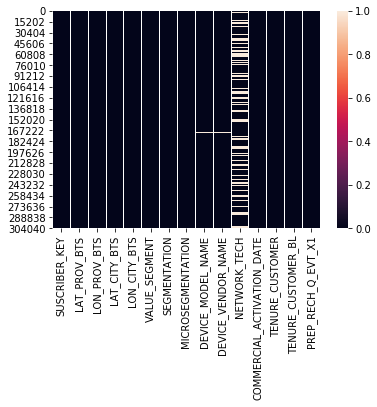

In [27]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [28]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [29]:
missing = pd.Series(nullcount)

In [30]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

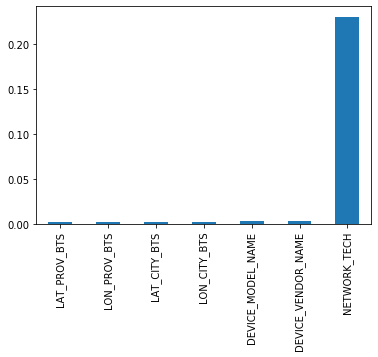

In [31]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

In [32]:
fulldata.shape[0]

319222

## Imputar network tech

In [33]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467399
3G     0.272118
NaN    0.229959
2G     0.030524
Name: NETWORK_TECH, dtype: float64

In [34]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    149204
3G      86866
NaN     73408
2G       9744
Name: NETWORK_TECH, dtype: int64

In [35]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int64(98), object(10)
memory usage: 465.2+ MB


In [36]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [37]:
cat_columns

['DEVICE_VENDOR_NAME',
 'SEGMENTATION',
 'COMMERCIAL_ACTIVATION_DATE',
 'MICROSEGMENTATION',
 'DEVICE_MODEL_NAME',
 'SUSCRIBER_KEY',
 'PREP_RECH_LAST_DAY_12W',
 'NETWORK_TECH',
 'PREP_RECH_CHNNL_MODE12W',
 'VALUE_SEGMENT']

In [38]:
Cat_fulldata =  fulldata[['SEGMENTATION',
 'PREP_RECH_CHNNL_MODE12W',
 'DEVICE_MODEL_NAME',
 'COMMERCIAL_ACTIVATION_DATE',
 'PREP_RECH_LAST_DAY_12W',
 'DEVICE_VENDOR_NAME',
 'MICROSEGMENTATION',
 'NETWORK_TECH',
 'SUSCRIBER_KEY',
 'VALUE_SEGMENT']].copy()

In [39]:
Cat_fulldata.head(5)

,SEGMENTATION,PREP_RECH_CHNNL_MODE12W,DEVICE_MODEL_NAME,COMMERCIAL_ACTIVATION_DATE,PREP_RECH_LAST_DAY_12W,DEVICE_VENDOR_NAME,MICROSEGMENTATION,NETWORK_TECH,SUSCRIBER_KEY,VALUE_SEGMENT
0,2-PD,"N/A,3;UGW,9",G4 STYLUS (H540),15-FEB-19,19-AUG-19,LG,PD1,LTE,E_63734494_20190215,3 - SILVER
1,7-LOW,"UGW,1",NOT_IDENTIFIED,18-MAY-19,03-JUL-19,NOT_IDENTIFIED,LOW3,NaN,E_66977552_20190518,4 - BRONZE
2,6-OH,"N/A,3;UGW,4",NOT_IDENTIFIED,16-JAN-18,02-SEP-19,NOT_IDENTIFIED,LOW4,3G,E_69159695_20180116,3 - SILVER
3,7-LOW,"UGW,2",JENNY TV 2.8,16-APR-19,01-SEP-19,BLU,LOW3,LTE,E_65255730_20190416,3 - SILVER
4,3-DO,"N/A,1;UGW,4",GALAXY J1 (SM-J111MDS),01-DEC-16,05-SEP-19,SAMSUNG,DO3,LTE,E_67893872_20161201,3 - SILVER


In [40]:
Recargas = fulldata[['PREP_RECH_Q_EVT_X1','PREP_RECH_Q_EVT_X2','PREP_RECH_Q_EVT_X3','PREP_RECH_AMT_X1',
                     'PREP_RECH_AMT_X2','PREP_RECH_AMT_X3', 'PREP_RECH_Q_MON_12W', 'PREP_RECH_Q_TUE_12W',
                    'PREP_RECH_Q_WEN_12W','PREP_RECH_Q_THUR_12W','PREP_RECH_Q_FRI_12W','PREP_RECH_Q_SAT_12W',
                    'PREP_RECH_Q_SUN_12W','PREP_RECH_NDAYS_LASTRECH_12W',
                    'PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3',
                    'PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7',
                    'PREP_RECH_Q_EVT_W8','PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11',
                    'PREP_RECH_Q_EVT_W12','PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3',
                    'PREP_RECH_AMT_W4','PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8',
                    'PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12']].copy()

In [41]:
Recargas.head(5)

,PREP_RECH_Q_EVT_X1,PREP_RECH_Q_EVT_X2,PREP_RECH_Q_EVT_X3,PREP_RECH_AMT_X1,PREP_RECH_AMT_X2,PREP_RECH_AMT_X3,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W,PREP_RECH_NDAYS_LASTRECH_12W,PREP_RECH_Q_EVT_W1,...,PREP_RECH_Q_EVT_W10,PREP_RECH_Q_EVT_W11,PREP_RECH_Q_EVT_W12,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
0,6,8,4,8.5,13.0,6.0,4,4,4,3,3,3,5,22,0,...,0,0,0,0.0,0.0,3.5,5.0,3.0,8.5,0.0,1.5,6.0,0.0,0.0,0.0
1,0,0,3,0.0,0.0,2.0,0,0,3,0,0,0,0,69,0,...,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,6,4,3,8.0,6.0,1.5,3,3,3,3,0,3,4,8,3,...,0,3,0,1.5,2.0,1.5,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.5,0.0
3,4,0,0,7.0,0.0,0.0,0,3,0,0,0,0,3,9,0,...,0,0,0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,3,13.0,10.0,10.0,0,3,3,3,0,4,0,5,3,...,3,0,0,3.0,0.0,0.0,10.0,0.0,5.0,0.0,5.0,0.0,10.0,0.0,0.0


In [42]:
Recargas[['PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W1'
          ,'PREP_RECH_Q_EVT_X1']].head(5)

,PREP_RECH_Q_EVT_W4,PREP_RECH_Q_EVT_W3,PREP_RECH_Q_EVT_W2,PREP_RECH_Q_EVT_W1,PREP_RECH_Q_EVT_X1
0,4,4,0,0,6
1,0,0,0,0,0
2,3,3,3,3,6
3,0,3,3,0,4
4,3,0,0,3,4


In [43]:
Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W5',
          'PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8','PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10',
          'PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12','PREP_RECH_Q_EVT_X1','PREP_RECH_Q_EVT_X2','PREP_RECH_Q_EVT_X3']]

,PREP_RECH_Q_EVT_W1,PREP_RECH_Q_EVT_W2,PREP_RECH_Q_EVT_W3,PREP_RECH_Q_EVT_W4,PREP_RECH_Q_EVT_W5,PREP_RECH_Q_EVT_W6,PREP_RECH_Q_EVT_W7,PREP_RECH_Q_EVT_W8,PREP_RECH_Q_EVT_W9,PREP_RECH_Q_EVT_W10,PREP_RECH_Q_EVT_W11,PREP_RECH_Q_EVT_W12,PREP_RECH_Q_EVT_X1,PREP_RECH_Q_EVT_X2,PREP_RECH_Q_EVT_X3
0,0,0,4,4,3,6,0,3,4,0,0,0,6,8,4
1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3
2,3,3,3,3,0,4,0,0,0,0,3,0,6,4,3
3,0,3,3,0,0,0,0,0,0,0,0,0,4,0,0
4,3,0,0,3,0,3,0,3,0,3,0,0,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,5,0,0,0,5
319218,0,0,0,4,3,0,0,4,3,3,4,3,4,5,7
319219,3,0,3,4,0,3,3,3,0,0,0,3,6,5,3
319220,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3


In [44]:
Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4','PREP_RECH_AMT_W5',
         'PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8','PREP_RECH_AMT_W9','PREP_RECH_AMT_W10',
         'PREP_RECH_AMT_W11','PREP_RECH_AMT_W12','PREP_RECH_AMT_X1','PREP_RECH_AMT_X2','PREP_RECH_AMT_X3']].head(5)

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12,PREP_RECH_AMT_X1,PREP_RECH_AMT_X2,PREP_RECH_AMT_X3
0,0.0,0.0,3.5,5.0,3.0,8.5,0.0,1.5,6.0,0.0,0.0,0.0,8.5,13.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
2,1.5,2.0,1.5,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.5,0.0,8.0,6.0,1.5
3,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
4,3.0,0.0,0.0,10.0,0.0,5.0,0.0,5.0,0.0,10.0,0.0,0.0,13.0,10.0,10.0


## Veamos si se cumple que la suma de las semanas sean igual que el valor que acumulan los meses, para las columnas referidas a recargas

### Empecemos comparando "cantidad de recargas"

In [64]:
Rec_Acum_mes1=Recargas[['PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W1'
                          ]].sum(axis=1)

In [67]:
Rec_Acum_mes2=Recargas[['PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8'
                          ]].sum(axis=1)

In [68]:
Rec_Acum_mes3=Recargas[['PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12'
                          ]].sum(axis=1)

### Vemos que la cantidad de Erroneos es considerable, así que decidimos extraer las columnas por considerarlas como información incorrecta

In [84]:
(Rec_Acum_mes1 == Recargas['PREP_RECH_Q_EVT_X1']).value_counts()

False    191491
True     127731
dtype: int64

In [85]:
(Rec_Acum_mes2 == Recargas['PREP_RECH_Q_EVT_X2']).value_counts()

False    192949
True     126273
dtype: int64

In [86]:
(Rec_Acum_mes3 == Recargas['PREP_RECH_Q_EVT_X3']).value_counts()

False    201542
True     117680
dtype: int64

In [ ]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT' in x],inplace=True)

In [95]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)

### Ahora comparemos los montos recargados

In [81]:
Monto_Rec_Acum_mes1=Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4'
                             ]].sum(axis=1)

In [82]:
Monto_Rec_Acum_mes2=Recargas[['PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8'
                             ]].sum(axis=1)

In [83]:
Monto_Rec_Acum_mes3=Recargas[['PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12'
                             ]].sum(axis=1)

### En éste caso, las cantidades sumadas cada cuatro semanas tienen, prácticamente, el mismo valor que lo que nos muestran las cantidades mensuales

In [87]:
(Monto_Rec_Acum_mes1 == Recargas['PREP_RECH_AMT_X1']).value_counts()

True     319070
False       152
dtype: int64

In [88]:
(Monto_Rec_Acum_mes2 == Recargas['PREP_RECH_AMT_X2']).value_counts()

True     319061
False       161
dtype: int64

In [89]:
(Monto_Rec_Acum_mes3 == Recargas['PREP_RECH_AMT_X3']).value_counts()

True     319059
False       163
dtype: int64

## Teniendo en cuenta que la información que nos brindan las columnas de montos acumulados por mes, es igual a la suma por semana, consideramos a la misma como duplicada. Por lo tanto, también decidimos borrar las columnas de montos acumulados mensualmente.

In [96]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_AMT_X' in x],inplace=True)

In [97]:
fulldata.shape

(319222, 172)